# Develop regression models

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

### Global variables

In [2]:
X_TEST_START = 549500
X_TEST_STOP = 551500
X_STEP = 50

Y_TEST_START = 213550
Y_TEST_STOP = 213950
Y_STEP = 50

ELEVATION_START = -20
ELEVATION_STOP = 44
ELEVATION_STEP = 5

### Load data

In [3]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data.csv')
tb_data_path = os.path.join(DATA_DIR, 'TB_blue_data.csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

### Data pre-processing

In [4]:
assign_num_list = {'topsoil layer': 0,
                      'weathered rock': 1,
                      'hard rock': 2,
                      'soft rock': 3,
                      'weathered soil': 4,
                      'colluvial layer': 5,
                      'moderate rock': 6,
                      'sedimentary layer': 7,
                      'reclaimed layer': 8}

In [5]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X','Y','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalized_X_train_ntb = normalizer.fit_transform(X_train_ntb)
normalized_X_train_tb = normalizer.fit_transform(X_train_tb)

# Deterministic Models

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

###  Shallow ANN

In [12]:
model = Sequential()
model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model.fit(normalized_X_train_ntb, y_train_ntb, 
          epochs = 1000, verbose=0)

## Predict and 3D visualize

### Create test area

In [16]:
def test_area_generate():
    test_area = np.empty((0,3), int)
    row = np.array([])
    for x in tqdm(range(X_TEST_START, X_TEST_STOP,X_STEP)):
        for y in range(Y_TEST_START, Y_TEST_STOP,Y_STEP):
            for elevation in range(ELEVATION_START, ELEVATION_STOP, ELEVATION_STEP):
                row = np.array([x,y,elevation])
                row = np.expand_dims(row,axis=0)
    #             print(row.shape)
                test_area = np.append(test_area, row, axis = 0)
#             print('Locationx: {}, y: {}, elevation: {}'.format(x,y,elevation))
    return test_area

In [17]:
X_test = test_area_generate()

100%|██████████| 40/40 [00:00<00:00, 538.42it/s]


In [19]:
X_test

array([[549500, 213550,    -20],
       [549500, 213550,    -15],
       [549500, 213550,    -10],
       ...,
       [551450, 213900,     30],
       [551450, 213900,     35],
       [551450, 213900,     40]])

In [20]:
normalized_X_test = normalizer.fit_transform(X_test)

In [21]:
def estimate_soil_properties(test_area):
    results = []
    for i in tqdm(range(len(test_area))):
        test_location = normalized_X_test[i]
        test_location = np.expand_dims(test_location, axis =0)
        result = model.predict(test_location)
        results.append(int(result))
    return results

In [22]:
y_estimate = estimate_soil_properties(test_area = X_test)

100%|██████████| 4160/4160 [01:46<00:00, 38.99it/s]


In [23]:
def plot_data(x, y, labels, colours):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    

In [24]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [25]:
label_colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink']

In [26]:
merged_X = []
merged_y = []

merged_X = np.append(X_train_ntb, X_test, axis = 0)
merged_y = np.append(y_train_ntb, y_estimate, axis = 0)

# merged_X = np.append(merged_X, X_train_tb, axis = 0)
# merged_y = np.append(merged_y, y_train_tb, axis = 0)


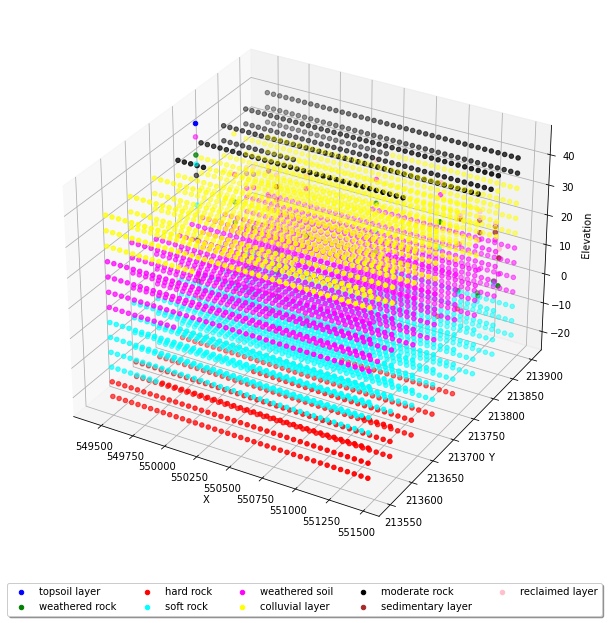

In [27]:
plot_data(merged_X, merged_y, labels, label_colours)
plt.show()

In [67]:
np.max(X_train_ntb[:,2])

44.73

In [65]:
np.min(X_train_ntb[:,2])

-21.6

In [66]:
X_train_ntb[:,2]

array([ 28.5 ,  26.  ,  21.5 ,   7.7 ,  -0.3 ,  -6.3 ,  -9.3 , -15.3 ,
       -17.5 ,  27.92,  25.92,  20.92,   0.42,  -3.78,  -6.48, -11.88,
       -14.58, -17.08,  30.31,  27.81,  19.31,   0.51,  -8.49, -14.49,
       -19.69,  31.3 ,  27.4 ,  23.  ,   6.  ,   0.5 ,  -1.6 ,  -4.5 ,
        -7.5 , -10.  , -19.6 , -21.  ,  31.37,  27.17,  11.17,  -2.13,
       -16.93, -19.83,  33.9 ,  27.4 ,  19.4 ,   9.9 ,   2.8 , -21.6 ,
        35.  ,  31.  ,  22.  ,  13.3 , -10.  ,  24.55,  23.55,  15.05,
        -0.75,  -1.95,  -6.95,  21.2 ,  18.2 ,  11.7 ,  -6.5 ,  -9.5 ,
        21.28,  16.28,   3.78,  -5.22,  20.15,  19.15,  17.15,  14.65,
         0.65,  -0.35,  15.66,  12.66,   7.26,   3.26,  44.73,  40.23,
        34.23,  31.23,  27.43,  17.43,   5.43,  -0.57,  -6.57,  -8.77,
       -14.77,  37.5 ,  23.9 ,  14.5 ,   7.5 , -10.5 , -13.5 , -16.5 ])